# Overview

During the past week, two significant advancements have been made in my summer research project. The first one is related to the development of next predictive models - specifically, I have successfully implemented a Recurrent Neural Network (RNN) and its more sophisticated variant, Gated Recurrent Unit (GRU). The second big improvement this week was about bringing together different parts of our system into one unfied framework.

In regards to the first advancement, the implementation of the RNN and GRU models has been a crucial step forward. These models represent an evolution to process sequence data, offering enhanced predictive capabilities compared to previous models. Building these models required a deep understanding of their underlying mechanisms, and their successful implementation marks a significant milestone in the project.

The second noteworthy accomplishment this week is related to the system architecture. After independently developing various models such as Bigram, MLP, WaveNet, RNN (and Transformer, which is currently in progress), I have started to integrate all these components into a single Python script along with two helper scripts. This consolidated framework will provide a command-line interface that allows users to effortlessly train and inference models on any given word collection. By selecting their preferred model and parameters, users can easily customize the system according to their specific needs.

This week's work has not only advanced capabilities in terms of predictive modeling but has also significantly improved the user accessibility and efficiency of the proposed system. Looking forward, I aim to complete the Transformer model and fully integrate it into the unified framework, thereby offering an even broader range of predictive models for users to choose from.
<br>

# Import necessary dependencies

In [28]:
import os
import time
from dataclasses import dataclass

# modelling
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter

# dataset reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# helper functions for both dataset preparation and model training and inference
from dataset_utils import clean_and_train_test_split, CharacterDataset, ContinuousDataLoader
from model_helpers import ModelConfig, display_samples, create_tokens, evaluate

## Spelling-out `model_helpers` and `dataset_utils`
<br>

### `model_helpers`

This set of functions and classes mainly aids in managing and manipulating the models and their outputs. The functions in this module include those for generating new tokens, displaying model-generated samples, and evaluating a model's performance.

1. `ModelConfig` class: This is a configuration class for the model parameters. It's used to store hyperparameters like the number of layers in the model (`n_layer`), the embedding size (`n_embd` and `n_embd2`), and the number of heads in the model (`n_head`), along with properties of the data such as the block size (`block_size`) and vocabulary size (`vocab_size`).
<br>

In [29]:
@dataclass
class ModelConfig:
    """
    This is a simple data class for storing model configuration settings. It includes settings related to the model architecture, such as the number of layers, the embedding size, and the number of heads, as well as settings related to the input data, such as the block size and vocabulary size.
    """
    block_size: int = None # input sequences length
    vocab_size: int = None # (0, vocab_size -1)
    # model parameters for different layers
    n_layer: int = 4
    n_embd: int = 64
    n_embd2: int = 64
    n_head: int = 4

<br><br>
2. `create_tokens` function: This function generates new tokens or characters from the given model. It starts from a provided sequence of indices, and based on the predictions of the model, it generates new tokens up to a maximum length defined by `max_token_creation`. If `sampling` is `True`, it will sample the next token based on the model's output distribution. Otherwise, it picks the token with the highest probability. If `top_k` is provided, it trims the predictions to only consider the top-k most probable tokens. This function returns a new sequence of tokens.
<br>

In [30]:
@torch.no_grad()
def create_tokens(model, sequence_indices, max_token_creation, sampling=False, top_k=None):
    """
    Generate new tokens from the given model, starting from a provided sequence of indices. This function can either sample the next token based on the model's output distribution or pick the token with the highest probability. It can also limit the prediction to the top-k most probable tokens.
    """
    sequence_limit = model.get_block_size()
    for _ in range(max_token_creation):
        # If the sequence context grows too large, it must be trimmed to sequence_limit
        sequence_condition = sequence_indices if sequence_indices.size(1) <= sequence_limit else sequence_indices[:, -sequence_limit:]
        # Pass the model forward to get the logits for the index in the sequence
        logits, _ = model(sequence_condition)
        logits = logits[:, -1, :]
        # Optionally trim the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        # Apply softmax to convert logits to (normalized) probabilities
        probabilities = F.softmax(logits, dim=-1)
        # Either sample from the distribution or take the most likely element
        if sampling:
            next_index = torch.multinomial(probabilities, num_samples=1)
        else:
            _, next_index = torch.topk(probabilities, k=1, dim=-1)
        # Append sampled index to the ongoing sequence and continue
        sequence_indices = torch.cat((sequence_indices, next_index), dim=1)

    return sequence_indices

<br><br>
3. `display_samples` function: This function displays some generated samples from the model. It first creates an initial sequence of zeros and generates subsequent tokens using the `create_tokens` function. Then it checks if the generated samples are in the training set, testing set, or if they are completely new words. It finally prints out the generated samples.
<br>

In [31]:
def display_samples(device, train_dataset, model, quantity=10):
    """
    Display some generated samples from the model. This function generates samples, checks if they are in the training set, testing set, or completely new, and prints out the generated samples.
    """    
    starting_input = torch.zeros(quantity, 1, dtype=torch.long).to(device)
    generation_steps = train_dataset.get_output_length() - 1 # -1 due to initial <START> token (index 0)
    sampled_input = create_tokens(model, starting_input, generation_steps, top_k=None, sampling=True).to(device)
    training_words, testing_words, novel_words = [], [], []
    for i in range(sampled_input.size(0)):
        # Obtain the i'th row of sampled integers, as python list
        sequence_row = sampled_input[i, 1:].tolist() # Remove the <START> token
        # Token 0 is the <STOP> token, thus we truncate the output sequence at that point
        stop_index = sequence_row.index(0) if 0 in sequence_row else len(sequence_row)
        sequence_row = sequence_row[:stop_index]
        sample_word = train_dataset.decode(sequence_row)
        # Check which words are in the training/testing set and which are new
        if train_dataset.contains(sample_word):
            training_words.append(sample_word)
        elif train_dataset.contains(sample_word):
            testing_words.append(sample_word)
        else:
            novel_words.append(sample_word)
    print('-'*50)
    for word_list, descriptor in [(training_words, 'in training'), (testing_words, 'in testing'), (novel_words, 'new')]:
        print(f"{len(word_list)} samples that are {descriptor}:")
        for word in word_list:
            print(word)
    print('-'*50)

In [32]:
@torch.inference_mode()
def evaluate(model, dataset, device, batch_size=50, max_batches=None):
    """
    Evaluate the model on the provided dataset. This function calculates the average loss of the model on the dataset, optionally limiting the evaluation to a certain number of batches.
    """
    model.eval() # evaluation mode
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=0)
    losses = []
    for i, batch in enumerate(loader):
        batch = [t.to(device) for t in batch]
        X, Y = batch
        logits, loss = model(X, Y)
        losses.append(loss.item())
        if max_batches is not None and i >= max_batches:
            break
    mean_loss = torch.tensor(losses).mean().item()
    model.train()
    return mean_loss

<br><br>
4. `evaluate` function: This function evaluates the model on a provided dataset. It creates a DataLoader for the dataset, runs the model in evaluation mode, and computes the average loss on the dataset. The model is then set back to training mode. If `max_batches` is specified, it limits the number of batches to evaluate. The function returns the average loss.
<br>

### `dataset_utils`

This set of functions and classes is primarily responsible for handling the dataset for training and evaluating the models. The functions in this module include those for data cleaning, splitting the data, encoding and decoding data samples, and providing continuous data loading for model training.
<br><br>

1. `clean_and_train_test_split`: This function performs several data preparation tasks. It reads a CSV file containing company names, cleans the names by removing leading/trailing spaces and empty names, and splits the data into a training set and a test set. It also creates an alphabet from the unique characters in the company names and prints out some information about the dataset. The function finally returns `CharacterDataset` objects for the training and test sets.
<br>

In [33]:
def clean_and_train_test_split():
    """
    Reads a CSV file of company names, cleans the names, creates an alphabet from the unique characters, splits the data into a training set and a test set, and returns `CharacterDataset` objects for the training and test sets.
    """
    df = pd.read_csv(
      "../data/cleansed_layer/companies_usa_size_over_10.csv", usecols=["name"]
    )
    
    # calling "words" instead of names as input data can be any collection of words
    words = df.name.to_list()

    # cleaning the data, removing and leading or ending spaces and deleting empty words
    words = [w.strip() for w in words] 
    words = [w for w in words if w]
    alphabet = sorted(list(set(''.join(words)))) # constructing the alphabets
    max_length = max(len(w) for w in words)
    print(f"word size in the data: {len(words)}")
    print(f"word with the maximum length: {max_length}")
    print(f"number of characters in the alphabet: {len(alphabet)}")
    print("alphabet: ", ''.join(alphabet))

    # train/test split (we'll use the test set to evaluate the model)
    test_set_size = min(1000, int(len(words) * 0.1))
    randp = torch.randperm(len(words)).tolist()
    train = [words[i] for i in randp[:-test_set_size]]
    test = [words[i] for i in randp[-test_set_size:]]
    print(f"train set size: {len(train)}, test set size: {len(test)}")

    train_dataset = CharacterDataset(train, alphabet, max_length)
    test_dataset = CharacterDataset(test, alphabet, max_length)

    return train_dataset, test_dataset

2. `CharacterDataset` class: This class extends PyTorch's `Dataset` class and is used for handling the company names dataset. It's initialized with a list of words (company names), an alphabet, and the maximum word length. It provides methods for:
   - Getting the size of the dataset
   - Checking if a word is in the dataset
   - Getting the size of the vocabulary
   - Getting the maximum sequence length
   - Encoding a word to indices and decoding indices to a word
   - Getting an item from the dataset by index


In [34]:
class CharacterDataset(Dataset):
    """
    A `Dataset` subclass for handling the company names dataset. Provides methods for encoding and decoding words, checking if a word is in the dataset, getting the size of the dataset, getting the size of the vocabulary, getting the maximum sequence length, and getting an item from the dataset.
    """

    def __init__(self, words, alphabet, max_word_length):
        self.words = words
        self.alphabet = alphabet
        self.max_word_length = max_word_length
        self.stoi = {ch:i+1 for i,ch in enumerate(alphabet)} # string to index encoding
        self.itos = {i:s for s,i in self.stoi.items()} # index to string decoding

    def __len__(self):
        return len(self.words)

    def contains(self, word):
        return word in self.words

    def get_vocab_size(self):
        return len(self.alphabet) + 1 # all the possible characters and special 0 token

    def get_output_length(self):
        return self.max_word_length + 1 # the longest word + 1 for the SOS token

    def encode(self, word):
        ix = torch.tensor([self.stoi[w] for w in word], dtype=torch.long)
        return ix

    def decode(self, ix):
        word = ''.join(self.itos[i] for i in ix)
        return word

    def __getitem__(self, idx):
        word = self.words[idx]
        ix = self.encode(word)
        x = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        y = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        x[1:1+len(ix)] = ix
        y[:len(ix)] = ix
        y[len(ix)+1:] = -1
        return x, y


<br><br>

3. `ContinuousDataLoader` class: This class creates an infinite data loader for a given dataset. The loader repeatedly iterates over the dataset in a random order. It provides a `get_next` method to get the next batch of data.

In [36]:
class ContinuousDataLoader:
    """
    A class for creating an infinite data loader for a given dataset. The loader repeatedly iterates over the dataset in a random order. Provides a `get_next` method to get the next batch of data.
    """
    def __init__(self, data_source, **loader_args):
        infinite_sampler = torch.utils.data.RandomSampler(data_source, replacement=True, num_samples=int(1e10))
        self.infinite_loader = DataLoader(data_source, sampler=infinite_sampler, **loader_args)
        self.data_iterator = iter(self.infinite_loader)

    def get_next(self):
        try:
            data_batch = next(self.data_iterator)
        except StopIteration:
            self.data_iterator = iter(self.infinite_loader)
            data_batch = next(self.data_iterator)
        return data_batch

In [37]:
# for reproducing results
seed = 10110609
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
work_dir = 'out' # model export directory
top_k = None

# Constructing RNN Architecture

Recurrent Neural Networks (RNNs) are a type of artificial neural network designed to recognize patterns in sequences of data, such as text, genomes, handwriting, or the spoken word. RNNs are called "recurrent" because they perform the same task for every element of a sequence, with the output depending on the previous computations. This recurrence mechanism allows information to be passed from one step of the sequence to the next.

In the context of character-based language modeling, RNNs are used to predict the next character in a sequence given the sequence of previous characters. Each input to the RNN corresponds to a character. The RNN maintains an internal state that it uses to capture the information about the characters it has seen so far. The output at each step is a probability distribution over the next character.

<b>Note: For the forward pass of the architecture please refer to the Docstrings for below codes.<b>

Also, Figure 1 very intuitive for understanding the forward pass of the vanilla RNN Cell.
<br><br>

## Vanilla RNN

![images/rnn_cell.png](images/rnn_cell.png)
<b><center> Figure 1: RNN Cell (Image sourced from the DeepLearning.AI Sequence Models course.) </center><b>

In [39]:
class RNNCell(nn.Module):
    """
    A basic RNN cell.

    This class represents the basic building block of a Recurrent Neural Network (RNN). 
    An RNN cell takes the current input and the previous hidden state to produce the 
    new hidden state. This operation is performed for every element in the input sequence.

    Args:
        config (ModelConfig): The configuration object containing the model parameters.
    """
    def __init__(self, config):
        """
        Initialize the RNN cell with a linear layer.

        The linear layer transforms the concatenated input and hidden state to the 
        new hidden state.

        Args:
            config (ModelConfig): The configuration object containing the model parameters.
        """
        super().__init__()
        self.xh_to_h = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2) # (128, 64)

    def forward(self, xt, hprev):
        """
        Perform the forward pass of the RNN cell.

        The forward pass involves concatenating the input and the previous hidden state, 
        and passing it through the linear layer. The output of the linear layer is 
        passed through a tanh activation function to produce the new hidden state.

        Args:
            xt (torch.Tensor): The input tensor at the current timestep.
            hprev (torch.Tensor): The hidden state at the previous timestep.

        Returns:
            ht (torch.Tensor): The hidden state at the current timestep.
        """
        # xt: input tensor
        # hprev: previous hidden state
        xh = torch.cat([xt, hprev], dim=1) # concat along y-axis
        ht = F.tanh(self.xh_to_h(xh)) # obtain new hidden state
        return ht

## GRU

While vanilla Recurrent Neural Networks (RNNs) are powerful models for sequence data, they suffer from the "vanishing gradients" problem. This problem occurs when gradients are backpropagated through time, from the output end of the sequence to the input end. As the sequence gets longer, these gradients can become increasingly small, until they practically vanish. This makes the model forget the earlier inputs. This issue poses a significant problem in tasks such as language modeling where the model needs to remember longer sequences of characters to make accurate predictions.

Gated Recurrent Units (GRUs) were introduced to solve this issue. GRUs incorporate gating mechanisms that allow each recurrent unit to adaptively control the flow of information from one time step to the next. This makes them better suited for handling longer sequences and dependencies between characters that are far apart.

In the context of character-based language modeling, a GRU can decide to remember a character that happened long ago if it believes it would be helpful in predicting future characters.

<b>Note: For the forward pass of the architecture please refer to the Docstrings for below codes.<b>


In [40]:
class GRUCell(nn.Module):
    """
    Gated Recurrent Unit (GRU) cell.

    The GRU cell is an improved version of the vanilla RNN cell that incorporates gating 
    mechanisms, specifically update and reset gates. These gates allow the GRU cell to 
    adaptively control the flow of information from one time step to the next, thereby 
    mitigating the vanishing gradient problem.

    Args:
        config (ModelConfig): The configuration object containing the model parameters.
    """
    def __init__(self, config):
    """
    Gated Recurrent Unit (GRU) cell.

    The GRU cell is an improved version of the vanilla RNN cell that incorporates gating 
    mechanisms, specifically update and reset gates. These gates allow the GRU cell to 
    adaptively control the flow of information from one time step to the next, thereby 
    mitigating the vanishing gradient problem.

    Args:
        config (ModelConfig): The configuration object containing the model parameters.
    """

    def __init__(self, config):
        """
        Initialize the GRU cell with three linear layers.

        The linear layers are used to compute the values of the update gate, reset gate, 
        and candidate hidden state.

        Args:
            config (ModelConfig): The configuration object containing the model parameters.
        """
        super().__init__()
        # input, forget, output, gate
        self.xh_to_z = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_r = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_hbar = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev):
        """
        Perform the forward pass of the GRU cell.

        The forward pass involves computing the update and reset gates, calculating the 
        candidate hidden state based on the reset gate, and then blending the previous 
        hidden state and the candidate hidden state using the update gate to produce 
        the new hidden state.

        Args:
            xt (torch.Tensor): The input tensor at the current timestep.
            hprev (torch.Tensor): The hidden state at the previous timestep.

        Returns:
            ht (torch.Tensor): The hidden state at the current timestep.
        """
        xh = torch.cat([xt, hprev], dim=1)
        r = F.sigmoid(self.xh_to_r(xh)) # reset gate
        hprev_reset = r * hprev
        xhr = torch.cat([xt, hprev_reset], dim=1)
        hbar = F.tanh(self.xh_to_hbar(xhr)) # candidate hidden state
        z = F.sigmoid(self.xh_to_z(xh)) # update gate
        ht = (1 - z) * hprev + z * hbar # new hidden state
        return ht

## RNN Model utilizing Vanilla or GRU implementations

The RNN class implements a full Recurrent Neural Network (RNN) model for character-based language modeling, using either a vanilla RNN cell or a Gated Recurrent Unit (GRU) cell, as defined by the `RNNCell` and `GRUCell` classes respectively.

In the `__init__` method, an embedding layer is created to transform the input character indices into dense vectors, a starting hidden state vector is initialized, and an RNN cell is chosen based on the cell_type parameter. Additionally, a linear layer is defined to transform the RNN cell's output into logits for each character in the vocabulary.

In the `forward` method, the input character indices are transformed into embeddings. Then, the model iteratively applies the RNN cell to each character embedding in the sequence, updating the hidden state at each step. These hidden states are collected and transformed into logits using the linear layer defined earlier. If target character indices are provided, a loss is computed comparing the logits to the targets.

More detailed explanation of `forward` pass:
- The forward method performs the forward pass of the RNN model. It takes the input indices idx and an  optional targets tensor for calculating the loss. The input indices idx represent a batch of sequences,  where each sequence is a list of integers representing the indices of tokens in the vocabulary.

- Inside the forward method, the RNN model first retrieves the device on which the input is located and  the batch size b and sequence length t from the input indices idx.

- The input indices idx are then passed through the embedding layer self.wte to obtain the embedded  representations emb of shape (b, t, n_embd). This step embeds all the integers in idx up front and  all at once for efficiency.

- The RNN model iterates over the inputs and updates the RNN state at each time step. It initializes the previous hidden state hprev as the starting hidden state expanded to match the batch dimension.  The hidden states at each time step are stored in a list hiddens.

- Within the loop, the input tensor xt is retrieved from the embedded representations emb for the current  time step i. The RNN cell self.cell is then called with xt and hprev to obtain the new hidden state ht.  The new hidden state ht is assigned to hprev, and it is added to the hiddens list.

- After the loop, the list of hidden states hiddens is stacked along the second dimension using torch.stack  to obtain a tensor of shape (b, t, n_embd2) called hidden.

- The hidden tensor is passed through the linear layer self.lm_head to obtain the logits, which represent  the scores for each token in the vocabulary. The logits have shape (b, t, vocab_size).

In [43]:
class RNN(nn.Module):
    """
    Recurrent Neural Network (RNN) for character-based language modeling.

    This class implements a full RNN model, using either a vanilla RNN cell or a Gated 
    Recurrent Unit (GRU) cell. The model transforms input character indices into 
    embeddings, applies the RNN cell in a recurrent manner to update a hidden state 
    for each character in the sequence, and transforms the final hidden states into 
    logits for each character in the vocabulary.

    Args:
        config (ModelConfig): The configuration object containing the model parameters.
        cell_type (str): The type of the RNN cell ('rnn' or 'gru').
    """
    def __init__(self, config, cell_type):
        """
        Initialize the RNN model with an embedding layer, an RNN cell, and a linear layer.

        Args:
            config (ModelConfig): The configuration object containing the model parameters.
            cell_type (str): The type of the RNN cell ('rnn' or 'gru').
        """
        super().__init__()
        # Initialize attributes using the configuration parameters
        self.block_size = config.block_size  # Maximum length of the input sequences
        self.vocab_size = config.vocab_size  # Total number of unique characters in the data

        # Initialize the starting hidden state as a trainable parameter
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2))  

        # Initialize the character embedding layer
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)  

        # Depending on the cell_type, initialize the appropriate type of RNN cell
        if cell_type == 'rnn':
            self.cell = RNNCell(config)
        elif cell_type == 'gru':
            self.cell = GRUCell(config)

        # Initialize the final linear layer to transform the RNN cell's output into logits for each character
        self.lm_head = nn.Linear(config.n_embd2, self.vocab_size)

    def get_block_size(self):
        """
        Get the size of the block (sequence length) for the RNN.

        Returns:
            block_size (int): The size of the block (sequence length).
        """
        # Return the maximum length of the input sequences
        return self.block_size

    def forward(self, idx, targets=None):
        """
        Perform the forward pass of the RNN model.

        The forward pass involves transforming the input character indices into embeddings, 
        applying the RNN cell in a recurrent manner to update a hidden state for each 
        character in the sequence, transforming the final hidden states into logits for 
        each character in the vocabulary, and optionally computing a loss.

        Args:
            idx (torch.Tensor): The input character indices.
            targets (torch.Tensor, optional): The target character indices.

        Returns:
            logits (torch.Tensor): The logits for each character in the vocabulary.
            loss (torch.Tensor, optional): The loss comparing the logits to the targets, 
                if targets are provided.
        """
        # Get the device of the input tensors and the batch size and sequence length
        device = idx.device
        b, t = idx.size()  

        # Embed the input indices for each character
        emb = self.wte(idx)

        # Initialize the hidden state to the starting hidden state
        hprev = self.start.expand((b, -1))  

        # Sequentially apply the RNN cell to each input and update the hidden state
        hiddens = []
        for i in range(t):
            # Get the embedding for the i-th character in each sequence
            xt = emb[:, i, :]  
            # Update the hidden state using the RNN cell
            ht = self.cell(xt, hprev)  
            # Set the previous hidden state for the next iteration
            hprev = ht  
            # Store the hidden state
            hiddens.append(ht)

        # Stack the hidden states into a tensor
        hidden = torch.stack(hiddens, 1)

        # Apply the linear layer to transform the hidden states into logits
        logits = self.lm_head(hidden)

        # If targets are provided, compute the loss
        loss = None
        if targets is not None:
            # Compute the cross-entropy loss between the logits and the targets
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        # Return the logits and the loss
        return logits, loss


# Preparing datasets

In [45]:
train_dataset, test_dataset = clean_and_train_test_split()
vocab_size = train_dataset.get_vocab_size() # 26 letter plus end token (".")
block_size = train_dataset.get_output_length() # max lenght word + 1
print(f"{vocab_size=}, {block_size=}")

word size in the data: 91073
word with the maximum length: 16
number of characters in the alphabet: 26
alphabet:  abcdefghijklmnopqrstuvwxyz
train set size: 90073, test set size: 1000
vocab_size=27, block_size=17


In [46]:
# model configurations
n_layer = 4
n_head = 4
n_embd = 64
n_embd2 = 64
    
config = ModelConfig(vocab_size=vocab_size, block_size=block_size,
                   n_layer=n_layer, n_head=n_head,
                   n_embd=n_embd, n_embd2=n_embd2)

# Training the models, both Vanilla RNN and GRU

## Vanilla RNN Training

In [50]:
model = RNN(config, cell_type='rnn')
# now using more advanced optimizer rather than SGD`
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01, betas=(0.9, 0.99), eps=1e-8)
batch_loader = ContinuousDataLoader(train_dataset, batch_size=32, pin_memory=True, num_workers=4)
writer = SummaryWriter(log_dir=work_dir)

print(f"model #params: {sum(p.numel() for p in model.parameters())}")

model #params: 11803


In [51]:
model

RNN(
  (wte): Embedding(27, 64)
  (cell): RNNCell(
    (xh_to_h): Linear(in_features=128, out_features=64, bias=True)
  )
  (lm_head): Linear(in_features=64, out_features=27, bias=True)
)

In [84]:
max_steps = 100000
best_loss = None
step = 0

In [ ]:
train_losses, test_losses = [], []

In [ ]:
while True:

    t0 = time.time()

    # batch loading
    batch = batch_loader.get_next()
    batch = [t.to(device) for t in batch]
    X, Y = batch

    # fitting into model
    logits, loss = model(X, Y)

    # parameter optimization
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Ensure that all CUDA operations are complete before measuring the time.
    if device.startswith('cuda'):
        torch.cuda.synchronize()
    t1 = time.time()

    # logging and tracking stats
    if step % 10 == 0:
        print(f"step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms")

    # evaluate the model
    if step > 0 and step % 500 == 0:
        train_lossi = evaluate(model, train_dataset, device, batch_size=100, max_batches=10)
        test_lossi  = evaluate(model, test_dataset, device, batch_size=100, max_batches=10)
        train_losses.append(train_lossi)
        test_losses.append(test_lossi)
        writer.add_scalar("Loss/train", train_lossi, step)
        writer.add_scalar("Loss/test", test_lossi, step)
        writer.flush()
        print(f"step {step} train loss: {train_lossi} test loss: {test_lossi}")
        # save the model
        if best_loss is None or test_lossi < best_loss:
            out_path = os.path.join(work_dir, "model.pt")
            print(f"test loss {test_lossi} is the best so far, saving model to {out_path}")
            torch.save(model.state_dict(), out_path)
            best_loss = test_lossi

    # sample from the model
    if step > 0 and step % 200 == 0:
        display_samples(device, train_dataset, model, quantity=10)

    step += 1
    # termination conditions
    if max_steps >= 0 and step >= max_steps:
      break

![images/vanilla_rnn_training_snapshot.png](images/vanilla_rnn_training_snapshot.png)
<b><center> Figure 2: This is snapshot from the rnn training logging, deleted whole logs as it takes huge place.</center><b>

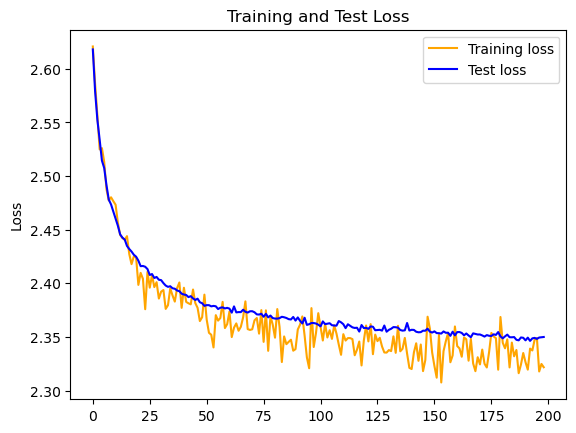

In [76]:
steps = [i for i in range(199)]
plt.plot(steps, train_losses, 'orange', label='Training loss')
plt.plot(steps, test_losses, 'blue', label='Test loss') 
plt.title('Training and Test Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()